In [1]:
import pandas as pd
import re
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
from textblob import TextBlob
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder \
    .appName("Sentiment_Analysis") \
    .getOrCreate()

In [3]:
df = spark.read.load("./data/data_tweet_music.csv",
                     format="csv", inferSchema="true", header="true")

In [4]:
df.show(5,True)
df.printSchema()

+--------------------+--------------------+
|                User|               Tweet|
+--------------------+--------------------+
|              pjs814|RT @Melissa048992...|
|I’m listening to ...|                null|
|         pjmmycatdog|RT @Marvicky24: B...|
|   WITH YOU 💙 JIMIN|                null|
|I’m listening to ...|                null|
+--------------------+--------------------+
only showing top 5 rows

root
 |-- User: string (nullable = true)
 |-- Tweet: string (nullable = true)



In [5]:
#data cleaning
def preprocessing(lines):
    words = lines.na.replace('', None)
    words = words.na.drop()
    words = words.withColumn('Tweet', F.regexp_replace('Tweet', r'http\\S+', ''))
    words = words.withColumn('Tweet', F.regexp_replace('Tweet', '@\\w+', ''))
    words = words.withColumn('Tweet', F.regexp_replace('Tweet', '#', ''))
    words = words.withColumn('Tweet', F.regexp_replace('Tweet', 'RT', ''))
    words = words.withColumn('Tweet', F.regexp_replace('Tweet', ':', ''))    
    return words

In [6]:
# text classification
def polarity_detection(text):
    return TextBlob(text).sentiment.polarity
def subjectivity_detection(text):
    return TextBlob(text).sentiment.subjectivity
def text_classification(words):
    # polarity detection
    polarity_detection_udf = udf(polarity_detection, StringType())
    words = words.withColumn("polarity", polarity_detection_udf("Tweet"))
    # subjectivity detection
    subjectivity_detection_udf = udf(subjectivity_detection, StringType())
    words = words.withColumn("subjectivity", subjectivity_detection_udf("Tweet"))
    return words

In [7]:
words = preprocessing(df)
words = text_classification(words)
words = words.repartition(1)

In [8]:
words.show()

+---------------+--------------------+--------------------+-------------------+
|           User|               Tweet|            polarity|       subjectivity|
+---------------+--------------------+--------------------+-------------------+
|         pjs814|    BE GOOD BE LI...|                 0.7| 0.6000000000000001|
|    pjmmycatdog|  BE GOOD BE LIKE...|                 0.7| 0.6000000000000001|
| chejiminie5813|  Jimin's Twitter...|                 0.0|                0.0|
|mlcTcdAX6jOfKC0|    My favorite B...|                0.25|               0.75|
|    gortizpolly|  Jensen taking o...| 0.07499999999999998| 0.7250000000000001|
|      MommyLouV|  ChickenNoodleSo...|                 0.0|                0.0|
|      YxinBts13|    Forever in lo...|               0.375| 0.7250000000000001|
|Korazon24698179|  We are trying/e...|                0.25| 0.5916666666666667|
|      951013sea|     I’m listenin...|                0.25| 0.8500000000000001|
|0s6nV4UuDikw11A|    I’m listening...|  

In [9]:
type(words)

pyspark.sql.dataframe.DataFrame

In [10]:
words = words.toPandas()
words

,User,Tweet,polarity,subjectivity
0,pjs814,BE GOOD BE LIKE JIMIN,0.7,0.6000000000000001
1,pjmmycatdog,BE GOOD BE LIKE JIMIN,0.7,0.6000000000000001
2,chejiminie5813,Jimin's Twitter Trends | Worldwide 🌎,0.0,0.0
3,mlcTcdAX6jOfKC0,My favorite Billboard trending song is def...,0.25,0.75
4,gortizpolly,Jensen taking over the trending topics true ...,0.07499999999999998,0.7250000000000001
...,...,...,...,...
10633,ZilBlondie,Guess who's trending again on CoinGecko 🦎,0.0,0.0
10634,Wecantgiveup7,I'm listening to BTS_Butter by BTS for My Tren...,0.0,0.0
10635,TxnTDGpqusufnrT,I’m listening to the hot trending song WithYou...,0.25,0.8500000000000001
10636,RADIO_CLN,Exile - Kiss You All Over on https//t.co/wiiiN...,0.0,0.0


In [11]:
words.dtypes

User            object
Tweet           object
polarity        object
subjectivity    object
dtype: object

In [12]:
words[["polarity", "subjectivity"]] = words[["polarity", "subjectivity"]].apply(pd.to_numeric)

In [13]:
tweet_polarity=[]
for i in words['polarity']:
    if i > 0 :
        i = 'Positive'
        tweet_polarity.append(i)
    else:
        i = 'Negative'
        tweet_polarity.append(i)

In [14]:
words['type_polarity'] = tweet_polarity
words

,User,Tweet,polarity,subjectivity,type_polarity
0,pjs814,BE GOOD BE LIKE JIMIN,0.700,0.600,Positive
1,pjmmycatdog,BE GOOD BE LIKE JIMIN,0.700,0.600,Positive
2,chejiminie5813,Jimin's Twitter Trends | Worldwide 🌎,0.000,0.000,Negative
3,mlcTcdAX6jOfKC0,My favorite Billboard trending song is def...,0.250,0.750,Positive
4,gortizpolly,Jensen taking over the trending topics true ...,0.075,0.725,Positive
...,...,...,...,...,...
10633,ZilBlondie,Guess who's trending again on CoinGecko 🦎,0.000,0.000,Negative
10634,Wecantgiveup7,I'm listening to BTS_Butter by BTS for My Tren...,0.000,0.000,Negative
10635,TxnTDGpqusufnrT,I’m listening to the hot trending song WithYou...,0.250,0.850,Positive
10636,RADIO_CLN,Exile - Kiss You All Over on https//t.co/wiiiN...,0.000,0.000,Negative


In [22]:
data_positive = words[words['type_polarity']=='Positive']['polarity'].count()

In [23]:
data_negative = words[words['type_polarity']=='Negative']['polarity'].count()

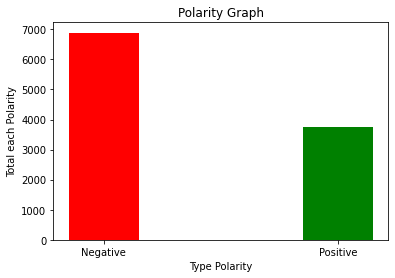

In [32]:
x = ['Negative','Positive']
y = [data_negative,data_positive]
left = [1,2]

plt.bar(left,y, tick_label = x,
        width = 0.3, color = ['red', 'green'])

# naming the x axis
plt.xlabel('Type Polarity')
# naming the y axis
plt.ylabel('Total each Polarity')
  
# giving a title to my graph
plt.title('Polarity Graph')
  
# function to show the plot
plt.show()

In [33]:
spark.stop()